Imports and setup

In [1]:
#%config InteractiveShell.ast_node_interactivity="last_expr_or_assign"

In [2]:
import csv, sys
import uproot
import pandas as pd
import numpy as np
import numpy.ma as ma
from numpy import array
import subprocess

np.set_printoptions(threshold=sys.maxsize)
import shap
import tensorflow as tf
import tkinter as tk
import matplotlib
import matplotlib.pyplot as plt
import os

# don't use these in notebook mode
#from matplotlib.backends.backend_pdf import PdfPages
#matplotlib.use("PDF")
import math
import time
from math import log, sqrt
from tensorflow import keras
from tensorflow.keras import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()  # Normalized data to range from (0,1)
from sklearn.metrics import (
    precision_recall_curve,
    plot_precision_recall_curve,
    average_precision_score,
    roc_curve,
    auc,
    roc_auc_score,
    precision_recall_curve,
    confusion_matrix
)
from datetime import datetime

# Checking if a GPU is available, not sure it will run in Jupyter
status = len(tf.config.experimental.list_physical_devices("GPU"))

# If we need a random seed.
seed = 42

some useful functions

In [3]:

def plotPR(x, y, t):
    #plt.subplot(411)
    plt.plot(t, x[:-1], "b--", label="Precision")
    plt.plot(t, y[:-1], "g-", label="Recall")
    plt.ylim([0.00, 1.05])
    plt.xlabel("Threshold")
    plt.title("Precision/Recall vs. Threshold Curve")
    plt.legend(loc="lower right")
    plt.grid()


def plotROC(x, y, AUC):
    plt.subplot(412)
    plt.plot(x, y, lw=1, label="ROC (area = %0.6f)" % (AUC))
    plt.plot([0, 1], [0, 1], "--", color=(0.6, 0.6, 0.6), label="Luck")
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic")
    plt.legend(loc="lower right")
    plt.grid()


def getZPoisson(s, b, stat, syst):
    """
    The significance for optimisation.
    s: total number of signal events
    b: total number of background events
    stat: relative MC stat uncertainty for the total bkg.
    syst: relative syst uncertainty on background
    Note that the function already accounts for the sqrt(b)
    uncertainty from the data, so we only need to pass in additional
    stat and syst terms.  e.g. the stat term above is really only
    characterizing the uncertainty due to limited MC statistics used
    to estimate the background yield.
    """
    n = s + b

    # this is a relative uncertainty
    sigma = math.sqrt(stat ** 2 + syst ** 2)

    # turn into the total uncertainty
    sigma = sigma * b

    if s <= 0 or b <= 0:
        return 0

    factor1 = 0
    factor2 = 0

    if sigma < 0.01:
        # In the limit where the total BG uncertainty is zero,
        # this reduces to approximately s/sqrt(b)
        factor1 = n * math.log((n / b))
        factor2 = n - b
    else:
        factor1 = n * math.log((n * (b + sigma ** 2)) / ((b ** 2) + n * sigma ** 2))
        factor2 = ((b ** 2) / (sigma ** 2)) * math.log(
            1 + ((sigma ** 2) * (n - b)) / (b * (b + sigma ** 2))
        )

    signif = 0
    try:
        signif = math.sqrt(2 * (factor1 - factor2))
    except ValueError:
        signif = 0

    return signif

This block defines the branch names that we'll pull from the tree. Luckily our current method of gathering data and weighting events does this for us, so this will remain commented out for the time being as it is redundant.

This block reads in the data from the input files, using the branches specified above.  So we should update this section to use the right input files, etc.  Note there's also some scaling of the samples to get the weights right.

In [4]:
SignalPath = '/home/jupyter-blonsbro/Combined Signal Ntuples, mjj>1000, MET>200, 3 jets.root'
EWKBackgroundPath = '/home/jupyter-blonsbro/Combined EWKBackground Ntuples, mjj>1000, MET>200, 3 jets.root'
QCDBackgroundPath = '/home/jupyter-blonsbro/Combined QCDBackground Ntuples, mjj>1000, MET>200, 3 jets.root'
names = ['Index','MET',"METPhi","j1PT","mjj","mjj_13","mjj_23","mjjoptimized","j1Eta","j2Eta","j3Eta","j1Phi","j2Phi","j3Phi","j2PT","j3PT","weight"]

In [5]:
SignalPath = '/home/jupyter-blonsbro/Combined Signal Ntuples1.root'
EWKBackgroundPath = '/home/jupyter-blonsbro/Combined EWKBackground Ntuples1.root'
QCDBackgroundPath = '/home/jupyter-blonsbro/Combined QCDBackground Ntuples1.root'
names = ['Index','MET',"METPhi","j1PT","mjj","mjj_13","mjj_23","mjjoptimized","j1Eta","j2Eta","j3Eta","j1Phi","j2Phi","j3Phi","j2PT","j3PT","weight"]

In [6]:
def RoottoTensorflow(filepath,SvB):
    Tree = uproot.open(filepath)
    Tree = Tree[SvB]
    branches = Tree.arrays()
    array=[]
    for item in branches['index']:
        subarray=[]
        for subitem in Tree.keys()[1:]:
            subarray.append(branches[item][subitem])
        array.append(subarray)
    dataset = tf.data.Dataset.from_tensor_slices(array)
    dataset = dataset.cache(filename = filepath+'_'+SvB)
    return(dataset)

In [7]:
def RoottoDataset(filepath, SvB, dropset):
    names = ['Index','MET',"METPhi","j1PT","mjj","mjj_13","mjj_23","mjjoptimized","j1Eta","j2Eta","j3Eta","j1Phi","j2Phi","j3Phi","j2PT","j3PT","weight"]
    Tree = uproot.open(filepath)
    Tree = Tree[SvB]
    branches = Tree.arrays()
    array=[]
    for i in range(len(branches)):
        subarray=[]
        for subitem in Tree.keys():
            subarray.append(branches[i][subitem])
        array.append(subarray)

    dataset = pd.DataFrame(array)
    dataset.columns =names
    dataset.drop("Index",axis = 1,inplace = True)
    dataset.drop("mjj",axis = 1,inplace = True)
    dataset.drop("mjj_13",axis = 1,inplace = True)
    dataset.drop("mjj_23",axis = 1,inplace = True)
    for dropvar in dropset:
        dataset.drop(dropvar,axis = 1,inplace = True)
    

    #dataset.drop("mjjoptimized",axis = 1,inplace = True)
    return(dataset)

In [8]:
# NN model defined as a function.
def build_model(network,RATE,numBranches):

    # Create a NN model. Barebones model with no layers.
    model = Sequential()

    # Best option for most NN.
    opt = keras.optimizers.Nadam()

    # Activation function other options possible.
    act = "relu"  # Relu is 0 for negative values, linear for nonzero values.

    # Use model.add() to add one layer at a time, 1st layer needs input shape, So we pass the 1st element of network.
    # Dense Layers are fully connected and most common.

    model.add(Dense(network[0], input_shape=(numBranches,), activation=act))

    # Loop through and add layers (1,(n-2)) where n is the number of layers. We end at n-2 because we start at 1 not zero and
    # we  the input layer is added above with input dimension. Therefore we must remove 2 from layers.
    for i in range(1, len(network) - 1):
        model.add(Dense(network[i], activation=act))  # Hidden layers.
        # Turning off nuerons of layer above in loop with pr  obability = 1-r, so r = 0.25, then 75% of nerouns are kept.
        model.add(Dropout(RATE, seed=seed))

    # Last layer needs to have one neuron for a binary classification(BC) which yields from 0 to 1.
    model.add(
        Dense(network[len(network)-1], activation="sigmoid")
    )  # Output layer's activation function for BC needs to be sigmoid.

    # Last step is compiling.
    model.compile(
        loss="binary_crossentropy",
        optimizer=opt,
        metrics=tf.keras.metrics.Precision(),
    )
    return model

In [9]:
def compare_train_test(kModel, model, X_train_df, y_train, X_test_df, y_test,Z_df, bins=40):
    """
    This creates the signal and background distrubution.
    """
    i = 0
    j = 0
    sig_index = []
    bkg_index = []
    decisions = []
    for X, y in ((X_train_df, y_train), (X_test_df, y_test)):
        # captures indices in X_train and X_test dataframes that correlate to signal and background events
        while i < len(y):
            if y[i] == 1.:
                sig_index.append(j)
            elif y[i] == 0.:
                bkg_index.append(j)
            i += 1
            j += 1
        i = 0
        d1 = model.predict(X[y > 0.5]).ravel()  # signal
        d2 = model.predict(X[y < 0.5]).ravel()  # background
        decisions += [d1, d2]
                
    low = min(np.min(d) for d in decisions)
    high = max(np.max(d) for d in decisions)
    low_high = array([low, high])
    
    train_s = decisions[0]
    train_b = decisions[1]
    test_s = decisions[2]
    test_b = decisions[3]
    
    #These lists contain re-seperated, non-gaussian event information
    learned_sig_l = []
    learned_bkg_l = []
    
    for item in sig_index:
        learned_sig_l.append(Z_df.loc[item])
    
    for item in bkg_index:
        learned_bkg_l.append(Z_df.loc[item])
        
    #Creating new indices for following dataframe
    lsig_ind = list(range(len(learned_sig_l)))
    lbkg_ind = list(range(len(learned_bkg_l)))
    
    #changing lists into dataframes
    learned_sig = pd.DataFrame(learned_sig_l, index=lsig_ind)
    learned_bkg = pd.DataFrame(learned_bkg_l, index=lbkg_ind)
        
    #Combining scores for test and training sets of signal and background seperately
    S_scores = np.concatenate((train_s, test_s), axis=None)
    B_scores = np.concatenate((train_b, test_b), axis=None)
    max_s = S_scores.max()
    
    #indices in scoring lists with scores greater than or equal too the dominant signal score
    passing_sig = []
    passing_bkg = []
    
    i = 0
    
    while i < len(S_scores):
        if S_scores[i] >= 0.15: #The number here needs to be updated according to scoring graph output
            passing_sig.append(i)
        i += 1    
        
    i = 0
        
    while i < len(B_scores):
        if B_scores[i] >= 0.15:
            passing_bkg.append(i)
        i += 1
    
    #lists of seperate signal and background event information with scores that were kept in the "passing" lists
    worthy_sig_l = []
    worthy_bkg_l = []
    
    for item in passing_sig:
        worthy_sig_l.append(learned_sig.loc[item])
        
    for item in passing_bkg:
        worthy_bkg_l.append(learned_bkg.loc[item])
        
    #Re-indexing dataframes
    wsig_ind = list(range(len(worthy_sig_l)))
    wbkg_ind = list(range(len(worthy_bkg_l)))
    
    #Dataframes for seperate signal and background events containing all physical feature information that also had scores
    #above or equal to the passing score
    worthy_sig = pd.DataFrame(worthy_sig_l, index=wsig_ind)
    worthy_bkg = pd.DataFrame(worthy_bkg_l, index=wbkg_ind)
    


In [10]:
def runNN(LAYER, BATCH, RATE, numBranches,X_train, X_test, y_train, y_test, Z_train, Z_test):
    """
    NN structure ex. [5,5,5,5,1] 4 layers with 5 neurons each and one output layer. LAYER value is
    the number of hidden layers excluding the output layer. Each hidden layer will contain the same
    amount of neurons (It is hard coded to be the number of features). The BATCH is the batch size,
    powers of 2 are perfered but any positive number works. RATE is the drop out rate; so a RATE = .5
    is half of the neurons being randomly turned off.
    """
    network = []
    numEpochs = 120  # Number of times the NN gets trained.
    batchSize = BATCH
    numLayers = LAYER
    neurons = numBranches

    # This creates a list that has the stucture of the NN.
    for i in range(numLayers - 1):
        network.append(neurons)
    network.append(1)
    numNeurons = sum(network)

    # This is a conformation that the script is starting and the NN structure is displayed.
    print("Script starting....\n", network)

    # This tags the output files with either GPU or CPU.
    if status == 1:
        print("GPU")
        sufix = ".GPU"
    else:
        sufix = ".CPU"
        print("CPU")

    # Start time for file name.
    startTime = datetime.now()
    pre = time.strftime("%Y.%m.%d_") + time.strftime("%H.%M.%S.")

    # Filename for keras model to be saved as.
    h5name = (
        "numLayers"
        + str(LAYER)
        + ".numBr anches"
        + str(neurons)
        + ".batchSize"
        + str(BATCH)
    )
    
    #determines user path to generate a model
    
    path = os.getcwd()
    
    modelName = path + '/' + pre + h5name + sufix + ".h5"

    # Filename for plots to be identified by saved model.
    figname = path + '/' + pre + ".plots"

    # Using model and setting parameters.
    model = build_model(network,RATE,numBranches)
    
    model.save(modelName)

    # This checkpoint is used for recovery of trained weights incase of interuption.
    checkPointsCallBack = ModelCheckpoint("temp.h5", save_best_only=True)

    # This terminates early if the monitor does not see an improvement after a certain
    # amount of epochs given by the patience.
    earlyStopCallBack = EarlyStopping(
        monitor="val_loss", patience=30, restore_best_weights=True
    )
        

    # This is where the training starts.
    kModel = model.fit(
        X_train,
        y_train,
        epochs=numEpochs,
        batch_size=batchSize,
        validation_data=(X_test, y_test),
        verbose=1,
        callbacks=[earlyStopCallBack, checkPointsCallBack]
    )
    
    return model,kModel,startTime,modelName

In [11]:
def storeModel(model,startTime,modelName,aucroc,X,y,scalefactor,X_test_df,y_test,nsig,nbkg):        
    # computes max signif
    numbins = 100000
    allScore = model.predict(X)
    sigScore = model.predict(X[y > 0.5]).ravel()
    bkgScore = model.predict(X[y < 0.5]).ravel()
    sigSUM = len(sigScore)
    bkgSUM = len(bkgScore)
    xlimit = (0, 1)
    tp = []
    fp = []
    hist, bins = np.histogram(sigScore, bins=numbins, range=xlimit, density=False)
    count = 0
    for i in range(numbins - 1, -1, -1):
        count += hist[i] / sigSUM
        tp.append(count)
    hist, bins = np.histogram(bkgScore, bins=numbins, range=xlimit, density=False)
    count = 0
    for j in range(numbins - 1, -1, -1):
        count += hist[j] / bkgSUM
        fp.append(count)
    area = auc(fp, tp)
    xplot = tp
    yplot = fp
    # computes max signif
    sigSUM = len(sigScore) * scalefactor
    tp = np.array(tp) * sigSUM
    fp = np.array(fp) * bkgSUM
    syst = 0.0
    stat = 0.0
    maxsignif = 0.0
    maxs = 0
    maxb = 0
    bincounter = numbins - 1
    bincountatmaxsignif = 999
    for t, f in zip(tp, fp):
        signif = getZPoisson(t, f, stat, syst)
        if f >= 10 and signif > maxsignif:
            maxsignif = signif
            maxs = t
            maxb = f
            bincountatmaxsignif = bincounter
            score = bincountatmaxsignif / numbins
        bincounter -= 1
    sig_to_N = maxs/maxb
    print(
        "\n Score = %6.3f\n Signif = %5.2f\n nsig = %d\n nbkg = %d\n Scored S/N = %d\n"
        % (score, maxsignif, maxs, maxb, sig_to_N)
    )
    runtime = datetime.now() - startTime
    areaUnderCurve = "{:.4f}".format(aucroc)
    maxsignif = "{:5.2f}".format(maxsignif)
    # This is the predicted score. Values range between [0,1]
    y_predicted = model.predict(X_test_df)
    # The score is rounded; values are 0 or 1.  This isn't actually used?
    y_predicted_round = [1 * (x[0] >= 0.5) for x in y_predicted]
    average_precision = average_precision_score(y_test, y_predicted)
    avgPer = "{0:0.4f}".format(average_precision)
    score = "{0:6.3f}".format(score)
    maxs = "%10d" % (maxs)
    maxb = "%10d" % (maxb)
    cm = confusion_matrix(y_test, y_predicted_round)
    CM = [cm[0][0], cm[0][1]], [cm[1, 0], cm[1, 1]]
    modelParam = [
        "FileName",
        "ConfusionMatrix [TP FP] [FN TN]",
        "Run Time",
        "AUC",
        "Avg.P",
        "Score",
        "Max Signif",
        "nsig",
        "nbkg",
        "Scored S/N",
    ]
    df = pd.DataFrame(
        np.array(
            [
                [
                    modelName,
                    CM,
                    runtime,
                    areaUnderCurve,
                    avgPer,
                    score,
                    maxsignif,
                    nsig,
                    nbkg,
                    sig_to_N,
                ]
            ]
        ),
        columns=modelParam,
    )
    df.to_csv(modelName, mode="a", header=False, index=False)
    print(df.to_string(justify="left", columns=modelParam, header=True, index=False))
    print("Saving model.....")
    print("old auc: \n", aucroc, "\n new auc", areaUnderCurve)
    model.save(modelName)  # Save Model as a HDF5 filein Data folder
    print("Model Saved")
    return allScore

In [12]:
def checkTraining(model,kModel,X_test_df,y_test,X_train_df,y_train,Z_df):
    # This is the predicted score. Values range between [0,1]
    y_predicted = model.predict(X_test_df)

    # Prediction, fpr,tpr and threshold values for ROC.
    fpr, tpr, thresholds = roc_curve(y_test, y_predicted)
    aucroc = auc(fpr, tpr)
    precision, recall, thresRecall = precision_recall_curve(y_test, y_predicted)
    
    figure, axs = plt.subplots(2, figsize=(6,10))
    axs[0].set_xlabel("Score")
    axs[0].set_ylabel("Distribution")
    axs[0].legend(loc="upper right")
    axs[0].plot(fpr, tpr, "r-", label="ROC (area = %0.6f)" % (aucroc))
    axs[0].plot([0, 1], [0, 1], "--", color=(0.6, 0.6, 0.6), label="Luck")
    axs[0].set_xlim([-0.05, 1.05])
    axs[0].set_ylim([-0.05, 1.05])
    axs[0].set_xlabel("False Positive Rate")
    axs[0].set_ylabel("True Positive Rate")
    axs[0].set_title("Receiver operating characteristic")
    axs[0].legend(loc="lower right")
    axs[0].grid(True)
    


    # AUC
    #plotROC(fpr, tpr, aucroc)

    axs[1].plot(thresRecall, precision[:-1], "b--", label="Precision")
    axs[1].plot(thresRecall, recall[:-1], "g-", label="Recall")
    axs[1].set_ylim([0.00, 1.05])
    axs[1].set_xlabel("Threshold")
    axs[1].set_title("Precision/Recall vs. Threshold Curve")
    axs[1].legend(loc="lower right")
    axs[1].grid(True)

    
    compare_train_test(kModel,model, X_train_df, y_train, X_test_df, y_test,Z_df)
    
    
    '''
    #This plots the important features.
    plot2 = plt.figure(2)
    backgrounds = X_train[np.random.choice(X_train.shape[0], 100, replace=False)]
    explainer = shap.DeepExplainer(model, backgrounds)
    shap_values = explainer.shap_values(X_test)
    shap.summary_plot(
        shap_values,
        X_train,
        plot_type="bar",
        feature_names=branches[:-1],
        max_display=25,
        title='Overfitting Check',
        legend_labels=['Training', 'Testing']
    )
    '''
    return aucroc

Significance

In [13]:
SignalPath = '/home/jupyter-blonsbro/Combined Signal Ntuples, mjj>1000, MET>200, 3 jets.root'
EWKBackgroundPath = '/home/jupyter-blonsbro/Combined EWKBackground Ntuples, mjj>1000, MET>200, 3 jets.root'
QCDBackgroundPath = '/home/jupyter-blonsbro/Combined QCDBackground Ntuples, mjj>1000, MET>200, 3 jets.root'

In [14]:
Signalbranches = RoottoDataset(SignalPath,'Signal',[])

In [15]:
EWKBackgroundbranches = RoottoDataset(EWKBackgroundPath,'EWKBackground',[])

In [16]:
QCDBackgroundbranches = RoottoDataset(QCDBackgroundPath,'QCDBackground',[])

In [17]:
A = Signalbranches
B = EWKBackgroundbranches
C = QCDBackgroundbranches

In [18]:
S_j1PT = A["j1PT"]
B_j1PT = np.append(B["j1PT"],C["j1PT"])
S_weight = A["weight"]
B_weight = np.append(B["weight"],C["weight"])
S_MET = A["MET"]
B_MET = np.append(B["MET"],C["MET"])
S_j1Eta = A["j1Eta"]
B_j1Eta = np.append(B["j1Eta"],C["j1Eta"])
S_j1Phi = A["j1Phi"]
B_j1Phi = np.append(B["j1Phi"],C["j1Phi"])
S_j2PT = A["j2PT"]
B_j2PT = np.append(B["j2PT"],C["j2PT"])
S_j2Eta = A["j2Eta"]
B_j2Eta = np.append(B["j2Eta"],C["j2Eta"])
S_j2Phi = A["j2Phi"]
B_j2Phi = np.append(B["j2Phi"],C["j2Phi"])
S_j3PT = A["j3PT"]
B_j3PT = np.append(B["j3PT"],C["j3PT"])
S_j3Eta = A["j3Eta"]
B_j3Eta = np.append(B["j3Eta"],C["j3Eta"])
S_j3Phi = A["j3Phi"]
B_j3Phi = np.append(B["j3Phi"],C["j3Phi"])

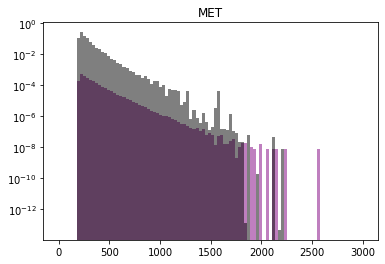

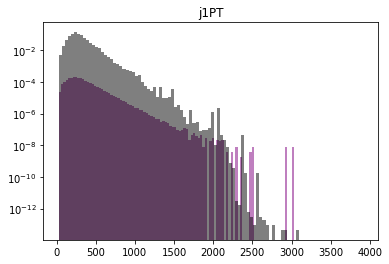

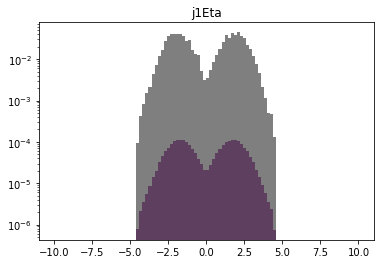

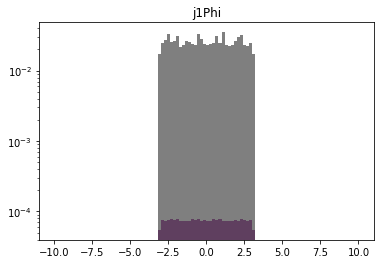

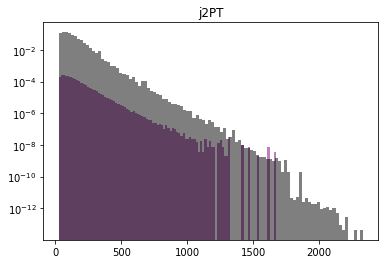

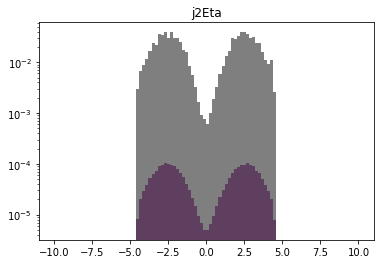

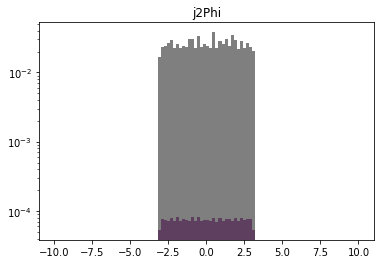

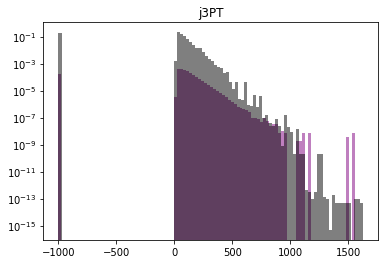

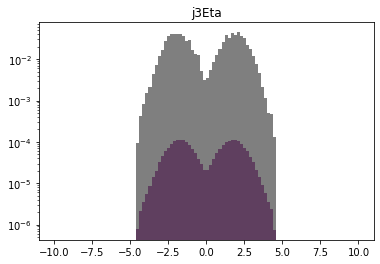

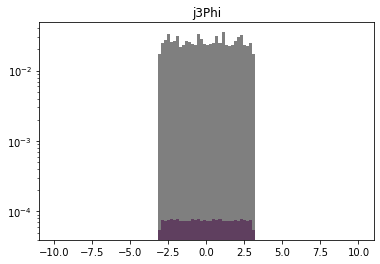

In [19]:
##Plot Graphs
##Feel Free to define these variables above and use these graph presets as a guide.
#MET
plt.hist(S_MET, bins=100, range=(0,3000), weights=S_weight, alpha=0.5, color = 'purple')
plt.hist(B_MET, bins=100, range=(0,3000), weights=B_weight, alpha=0.5, color = 'black')
plt.yscale('log')
plt.title("MET")
plt.show()
#j1PT
plt.hist(S_j1PT,bins=100,weights=S_weight, alpha=0.5, color='purple')
plt.hist(B_j1PT,bins=100,weights=B_weight, alpha=0.5, color='black')
plt.yscale('log')
plt.title("j1PT")
plt.show()
#j1Eta
plt.hist(S_j1Eta,bins=100,range=(-10,10),weights=S_weight, alpha=0.5, color='purple')
plt.hist(B_j1Eta,bins=100,range=(-10,10),weights=B_weight, alpha=0.5, color='black')
plt.yscale('log')
plt.title("j1Eta")
plt.show()
#j1Phi
plt.hist(S_j1Phi,bins=100,range=(-10,10),weights=S_weight, alpha=0.5, color='purple')
plt.hist(B_j1Phi,bins=100,range=(-10,10),weights=B_weight, alpha=0.5, color='black')
plt.yscale('log')
plt.title("j1Phi")
plt.show()
#j2PT
plt.hist(S_j2PT,bins=100,weights=S_weight, alpha=0.5, color='purple')
plt.hist(B_j2PT,bins=100,weights=B_weight, alpha=0.5, color='black')
plt.yscale('log')
plt.title("j2PT")
plt.show()
#j2Eta
plt.hist(S_j2Eta,bins=100,range=(-10,10),weights=S_weight, alpha=0.5, color='purple')
plt.hist(B_j2Eta,bins=100,range=(-10,10),weights=B_weight, alpha=0.5, color='black')
plt.yscale('log')
plt.title("j2Eta")
plt.show()
#j2Phi
plt.hist(S_j2Phi,bins=100,range=(-10,10),weights=S_weight, alpha=0.5, color='purple')
plt.hist(B_j2Phi,bins=100,range=(-10,10),weights=B_weight, alpha=0.5, color='black')
plt.yscale('log')
plt.title("j2Phi")
plt.show()
#j3PT
plt.hist(S_j3PT,bins=100,weights=S_weight, alpha=0.5, color='purple')
plt.hist(B_j3PT,bins=100,weights=B_weight, alpha=0.5, color='black')
plt.yscale('log')
plt.title("j3PT")
plt.show()
#j3Eta
plt.hist(S_j3Eta,bins=100,range=(-10,10),weights=S_weight, alpha=0.5, color='purple')
plt.hist(B_j3Eta,bins=100,range=(-10,10),weights=B_weight, alpha=0.5, color='black')
plt.yscale('log')
plt.title("j3Eta")
plt.show()
#j3Phi
plt.hist(S_j3Phi,bins=100,range=(-10,10),weights=S_weight, alpha=0.5, color='purple')
plt.hist(B_j3Phi,bins=100,range=(-10,10),weights=B_weight, alpha=0.5, color='black')
plt.yscale('log')
plt.title("j3Phi")
plt.show()

In [20]:
#turning important data into dataframe to be easily read or transferred if need be

list_signal = pd.DataFrame(Signalbranches)
list_ewk = pd.DataFrame(EWKBackgroundbranches)
list_qcd = pd.DataFrame(QCDBackgroundbranches)


#determining input neuron count

numBranches = len(list_signal.keys()) - 2

#getting counts for each input

nsig = len(list_signal['weight'])
nEWKbkg = len(list_ewk['weight'])
nQCDbkg = len(list_qcd['weight'])


df_background = list_ewk.append(list_qcd, ignore_index=True)
df_background = list_ewk

nbkg = len(df_background['weight'])


# The 3 backgrounds are concatenated we shuffle to make sure they are not sorted.
shuffleBackground = shuffle(df_background, random_state=seed)

#1/sum(weights)

scalefactor = sum(list_signal['weight'])/len(list_signal['weight'])

# Signal and shuffle background data.
rawdata = pd.concat([list_signal, shuffleBackground], ignore_index = True)

#Z is a non-guassian transformed, but equally ordered data set that provides as a clean copy of our original data

Z = rawdata

X = rawdata.drop(["mjjoptimized", "weight"], axis=1)

# Normalized the data with a Gaussian distrubuition with 0 mean and unit variance.
X = sc.fit_transform(X)

# Labeling data with 1's and 0's to distinguish.(1/positve/signal and 0/negative/background)
# Truth Labels.
y = np.concatenate((np.ones(len(list_signal)), np.zeros(len(shuffleBackground))))

# Shuffle full data and split into train/test and validation set.
X_dev, X_eval, y_dev, y_eval, Z_dev, Z_eval = train_test_split(
    X, y, Z, test_size=0.01, random_state=seed, stratify=y
)
X_train, X_test, y_train, y_test, Z_train, Z_test = train_test_split(
    X_dev, y_dev, Z_dev, test_size=0.2, random_state=seed, stratify=y_dev
)
#Changing all re-ordered data sets into dataframes
X_train_df = pd.DataFrame(X_train)
X_test_df = pd.DataFrame(X_test)
Z_df = Z_train.append(Z_test, ignore_index=True)

In [21]:
Xa = pd.DataFrame(X, columns =['MET',"METPhi","j1PT","j1Eta","j2Eta","j3Eta","j1Phi","j2Phi","j3Phi","j2PT","j3PT"] )

In [22]:
Za = pd.DataFrame(Z, columns =['MET',"METPhi","j1PT","j1Eta","j2Eta","j3Eta","j1Phi","j2Phi","j3Phi","j2PT","j3PT","weight"] )

In [23]:
Xa

,MET,METPhi,j1PT,j1Eta,j2Eta,j3Eta,j1Phi,j2Phi,j3Phi,j2PT,j3PT
0,0.009524,1.590995,-0.125516,-0.690734,0.730771,-0.690734,-0.153585,-1.570357,-0.153585,-0.566762,0.514054
1,-0.320070,-0.376586,0.003782,-0.157194,1.269791,-0.157194,1.313426,-0.717876,1.313426,-0.562727,-1.716217
2,3.485256,-1.550948,2.105767,-0.202616,0.991955,-0.202616,0.203277,-1.127453,0.203277,0.039117,0.522743
3,-0.770206,-1.030277,-0.794167,-1.150810,0.985898,-1.150810,0.538243,0.813649,0.538243,0.002349,0.616701
4,-0.268286,0.219472,-0.379873,-0.740594,0.780581,-0.740594,-1.671968,-1.365404,-1.671968,-0.572035,0.547918
...,...,...,...,...,...,...,...,...,...,...,...
1044494,0.460079,1.012505,1.454594,1.139242,-1.138164,1.139242,-1.015860,0.321661,-1.015860,1.047248,0.570763
1044495,-0.690525,-1.207109,-0.154587,1.178558,-0.877367,1.178558,-0.052307,1.282696,-0.052307,0.809337,-1.716217
1044496,-0.704664,0.080122,0.267989,-1.199979,0.769543,-1.199979,-1.664902,0.031816,-1.664902,0.206664,-1.716217
1044497,1.143867,0.940867,0.761265,0.654787,-0.661811,0.654787,-0.694756,1.664735,-0.694756,-0.122008,0.436848


In [24]:
Za

,MET,METPhi,j1PT,j1Eta,j2Eta,j3Eta,j1Phi,j2Phi,j3Phi,j2PT,j3PT,weight
0,306.334930,2.889699,313.957001,-1.716077,2.235141,-1.716077,-0.281606,-2.847373,-0.281606,81.440247,64.609825,3.876874e-09
1,267.412720,-0.680680,339.383698,-0.388212,3.887441,-0.388212,2.379335,-1.301068,2.379335,81.961365,-999.000000,3.876874e-09
2,716.789856,-2.811683,752.743774,-0.501257,3.035767,-0.501257,0.365689,-2.043993,0.365689,159.690918,68.753708,3.876874e-09
3,214.255310,-1.866872,182.465195,-2.861109,3.017203,-2.861109,0.973267,1.476947,0.973267,154.942261,113.561775,3.876874e-09
4,273.527924,0.400929,263.937073,-1.840169,2.387827,-1.840169,-3.035728,-2.475610,-3.035728,80.759300,80.759300,3.876874e-09
...,...,...,...,...,...,...,...,...,...,...,...,...
1044494,359.541687,1.839969,624.689087,2.838339,-3.493860,2.838339,-1.845644,0.584535,-1.845644,289.893311,91.654015,1.272105e-13
1044495,223.665024,-2.187752,308.239960,2.936188,-2.694419,2.936188,-0.097902,2.327745,-0.097902,259.166595,-999.000000,4.213460e-09
1044496,221.995361,0.148064,391.340637,-2.983479,2.353989,-2.983479,-3.022911,0.058790,-3.022911,181.329941,-999.000000,4.212099e-09
1044497,440.291321,1.709975,488.344513,1.632634,-2.033657,1.632634,-1.263211,3.020720,-1.263211,138.881241,27.790659,2.153244e-07


In [25]:
S_j1PT = Xa["j1PT"][0:len(list_signal)]
B_j1PT = Xa["j1PT"][len(list_signal):-1]
S_MET = Xa["MET"][0:len(list_signal)]
B_MET = Xa["MET"][len(list_signal):-1]
S_j1Eta = Xa["j1Eta"][0:len(list_signal)]
B_j1Eta = Xa["j1Eta"][len(list_signal):-1]
S_j1Phi = Xa["j1Phi"][0:len(list_signal)]
B_j1Phi = Xa["j1Phi"][len(list_signal):-1]
S_j2PT = Xa["j2PT"][0:len(list_signal)]
B_j2PT = Xa["j2PT"][len(list_signal):-1]
S_j2Eta = Xa["j2Eta"][0:len(list_signal)]
B_j2Eta = Xa["j2Eta"][len(list_signal):-1]
S_j2Phi = Xa["j2Phi"][0:len(list_signal)]
B_j2Phi = Xa["j2Phi"][len(list_signal):-1]
S_j3PT = Xa["j3PT"][0:len(list_signal)]
B_j3PT = Xa["j3PT"][len(list_signal):-1]
S_j3Eta = Xa["j3Eta"][0:len(list_signal)]
B_j3Eta = Xa["j3Eta"][len(list_signal):-1]
S_j3Phi = Xa["j3Phi"][0:len(list_signal)]
B_j3Phi = Xa["j3Phi"][len(list_signal):-1]

S_weight = Za["weight"][0:len(list_signal)]
B_weight = Za["weight"][len(list_signal):-1]

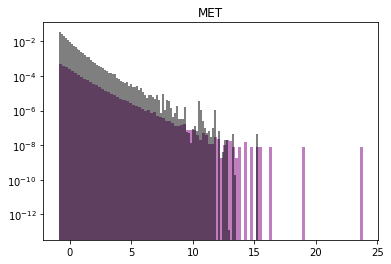

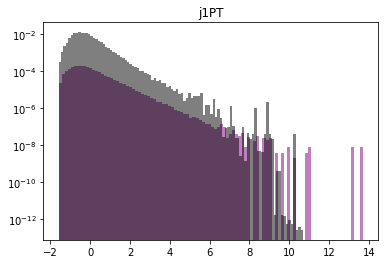

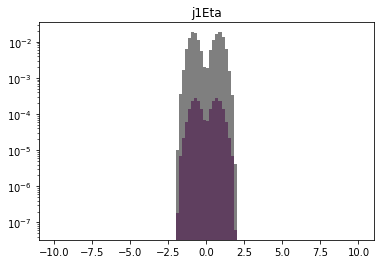

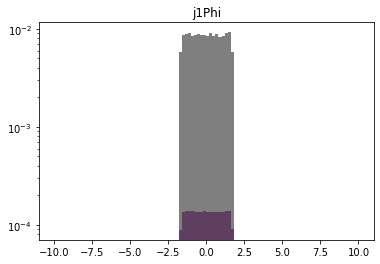

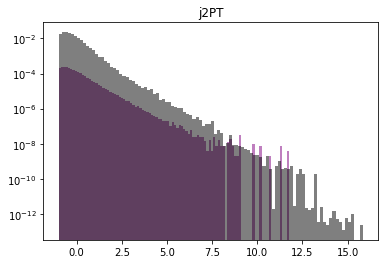

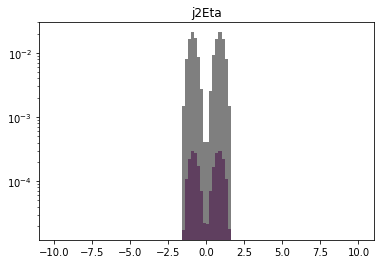

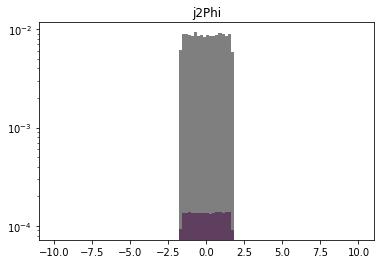

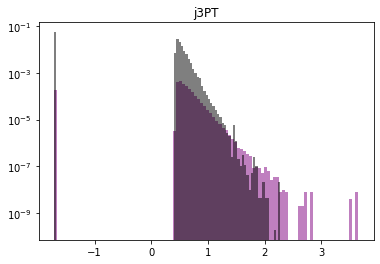

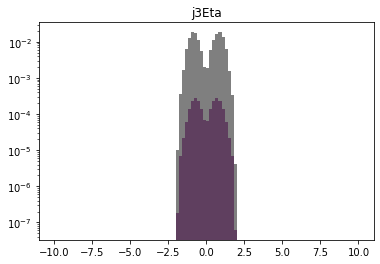

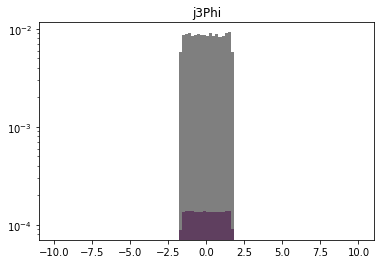

In [26]:
##Plot Graphs
##Feel Free to define these variables above and use these graph presets as a guide.
#MET
plt.hist(S_MET, bins=100, weights=S_weight, alpha=0.5, color = 'purple')
plt.hist(B_MET, bins=100, weights=B_weight, alpha=0.5, color = 'black')
plt.yscale('log')
plt.title("MET")
plt.show()
#j1PT
plt.hist(S_j1PT,bins=100,weights=S_weight, alpha=0.5, color='purple')
plt.hist(B_j1PT,bins=100,weights=B_weight, alpha=0.5, color='black')
plt.yscale('log')
plt.title("j1PT")
plt.show()
#j1Eta
plt.hist(S_j1Eta,bins=100,range=(-10,10),weights=S_weight, alpha=0.5, color='purple')
plt.hist(B_j1Eta,bins=100,range=(-10,10),weights=B_weight, alpha=0.5, color='black')
plt.yscale('log')
plt.title("j1Eta")
plt.show()
#j1Phi
plt.hist(S_j1Phi,bins=100,range=(-10,10),weights=S_weight, alpha=0.5, color='purple')
plt.hist(B_j1Phi,bins=100,range=(-10,10),weights=B_weight, alpha=0.5, color='black')
plt.yscale('log')
plt.title("j1Phi")
plt.show()
#j2PT
plt.hist(S_j2PT,bins=100,weights=S_weight, alpha=0.5, color='purple')
plt.hist(B_j2PT,bins=100,weights=B_weight, alpha=0.5, color='black')
plt.yscale('log')
plt.title("j2PT")
plt.show()
#j2Eta
plt.hist(S_j2Eta,bins=100,range=(-10,10),weights=S_weight, alpha=0.5, color='purple')
plt.hist(B_j2Eta,bins=100,range=(-10,10),weights=B_weight, alpha=0.5, color='black')
plt.yscale('log')
plt.title("j2Eta")
plt.show()
#j2Phi
plt.hist(S_j2Phi,bins=100,range=(-10,10),weights=S_weight, alpha=0.5, color='purple')
plt.hist(B_j2Phi,bins=100,range=(-10,10),weights=B_weight, alpha=0.5, color='black')
plt.yscale('log')
plt.title("j2Phi")
plt.show()
#j3PT
plt.hist(S_j3PT,bins=100,weights=S_weight, alpha=0.5, color='purple')
plt.hist(B_j3PT,bins=100,weights=B_weight, alpha=0.5, color='black')
plt.yscale('log')
plt.title("j3PT")
plt.show()
#j3Eta
plt.hist(S_j3Eta,bins=100,range=(-10,10),weights=S_weight, alpha=0.5, color='purple')
plt.hist(B_j3Eta,bins=100,range=(-10,10),weights=B_weight, alpha=0.5, color='black')
plt.yscale('log')
plt.title("j3Eta")
plt.show()
#j3Phi
plt.hist(S_j3Phi,bins=100,range=(-10,10),weights=S_weight, alpha=0.5, color='purple')
plt.hist(B_j3Phi,bins=100,range=(-10,10),weights=B_weight, alpha=0.5, color='black')
plt.yscale('log')
plt.title("j3Phi")
plt.show()

In [27]:
batch = 512

layers = 3

# This runs the training. A for loop can be used to vary the parameters. 
model,kModel,startTime,modelName=runNN(layers,batch,0.5, numBranches,X_train, X_test, y_train, y_test, Z_train, Z_test)

Script starting....
 [11, 11, 1]
CPU
Epoch 1/120
1616/1616 [==============================] - 2s 953us/step - loss: 0.5222 - precision: 0.6846 - val_loss: 0.3849 - val_precision: 0.7674
Epoch 2/120
1616/1616 [==============================] - 1s 876us/step - loss: 0.4386 - precision: 0.7715 - val_loss: 0.3619 - val_precision: 0.7822
Epoch 3/120
1616/1616 [==============================] - 1s 883us/step - loss: 0.4268 - precision: 0.7759 - val_loss: 0.3541 - val_precision: 0.7767
Epoch 4/120
1616/1616 [==============================] - 1s 883us/step - loss: 0.4229 - precision: 0.7800 - val_loss: 0.3495 - val_precision: 0.7817
Epoch 5/120
1616/1616 [==============================] - 1s 860us/step - loss: 0.4203 - precision: 0.7828 - val_loss: 0.3503 - val_precision: 0.7843
Epoch 6/120
1616/1616 [==============================] - 1s 881us/step - loss: 0.4153 - precision: 0.7823 - val_loss: 0.3451 - val_precision: 0.7805
Epoch 7/120
1616/1616 [==============================] - 1s 887us/ste

1616/1616 [==============================] - 1s 884us/step - loss: 0.4014 - precision: 0.7913 - val_loss: 0.3366 - val_precision: 0.7988
Epoch 56/120
1616/1616 [==============================] - 1s 867us/step - loss: 0.4009 - precision: 0.7920 - val_loss: 0.3377 - val_precision: 0.8019
Epoch 57/120
1616/1616 [==============================] - 1s 884us/step - loss: 0.4019 - precision: 0.7918 - val_loss: 0.3362 - val_precision: 0.7906
Epoch 58/120
1616/1616 [==============================] - 1s 864us/step - loss: 0.4016 - precision: 0.7917 - val_loss: 0.3371 - val_precision: 0.8020
Epoch 59/120
1616/1616 [==============================] - 1s 878us/step - loss: 0.4013 - precision: 0.7922 - val_loss: 0.3368 - val_precision: 0.8029
Epoch 60/120
1616/1616 [==============================] - 1s 876us/step - loss: 0.4014 - precision: 0.7922 - val_loss: 0.3368 - val_precision: 0.7906
Epoch 61/120
1616/1616 [==============================] - 1s 868us/step - loss: 0.4014 - precision: 0.7925 - val_

1616/1616 [==============================] - 1s 879us/step - loss: 0.4001 - precision: 0.7938 - val_loss: 0.3367 - val_precision: 0.8060
Epoch 110/120
1616/1616 [==============================] - 1s 898us/step - loss: 0.4003 - precision: 0.7939 - val_loss: 0.3354 - val_precision: 0.8008
Epoch 111/120
1616/1616 [==============================] - 1s 880us/step - loss: 0.3999 - precision: 0.7933 - val_loss: 0.3338 - val_precision: 0.7924
Epoch 112/120
1616/1616 [==============================] - 1s 888us/step - loss: 0.4003 - precision: 0.7937 - val_loss: 0.3355 - val_precision: 0.8023
Epoch 113/120
1616/1616 [==============================] - 1s 883us/step - loss: 0.4001 - precision: 0.7937 - val_loss: 0.3348 - val_precision: 0.7971
Epoch 114/120
1616/1616 [==============================] - 1s 884us/step - loss: 0.4000 - precision: 0.7941 - val_loss: 0.3351 - val_precision: 0.7956
Epoch 115/120
1616/1616 [==============================] - 1s 885us/step - loss: 0.3998 - precision: 0.7937 

No handles with labels found to put in legend.


Signal:  380221 
 EWK:  664278 
 QCD:  250804 
 All Background:  664278 
 S/N:  0.5723823459455228

 Score =  0.000
 Signif =  0.00
 nsig = 0
 nbkg = 662147
 Scored S/N = 0

FileName                                                                          ConfusionMatrix [TP FP] [FN TN]    Run Time               AUC     Avg.P   Score   Max Signif nsig    nbkg    Scored S/N  
 /home/examples/2022.06.22_13.36.58.numLayers3.numBr anches11.batchSize512.CPU.h5  ([116651, 14876], [16691, 58593]) 0 days 00:05:25.373751  0.9253  0.8600   0.000   0.00      380221  664278  3.56686e-09
Saving model.....
old auc: 
 0.9252833728016753 
 new auc 0.9253
Model Saved


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


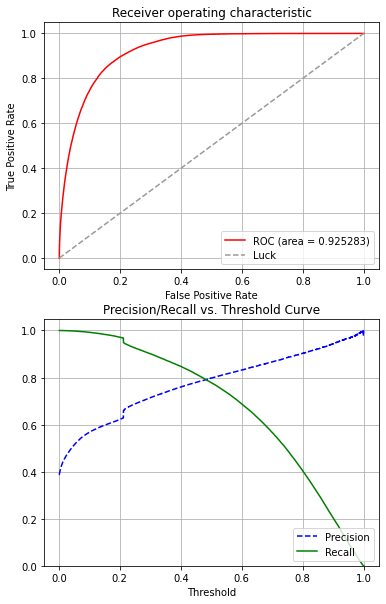

In [28]:
aucroc=checkTraining(model,kModel,X_test_df,y_test,X_train_df,y_train,Z_df)
print("Signal: ", nsig, "\n EWK: ", nEWKbkg, "\n QCD: ", nQCDbkg, "\n All Background: ", nbkg, "\n S/N: ", nsig/nbkg)
allScore = storeModel(model,startTime,modelName,aucroc,X,y,scalefactor,X_test_df,y_test,nsig,nbkg)

Text(0, 0.5, 'Loss')

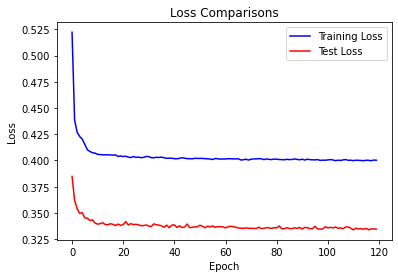

In [29]:
val_loss = kModel.history['val_loss']
loss = kModel.history['loss']
epochs = []

i = 0
while i < len(val_loss):
    epochs.append(i)
    i += 1

plt.plot(epochs, loss, color='blue', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Test Loss')
plt.legend(loc='upper right')
plt.title("Loss Comparisons")
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0, 0.5, 'Precision')

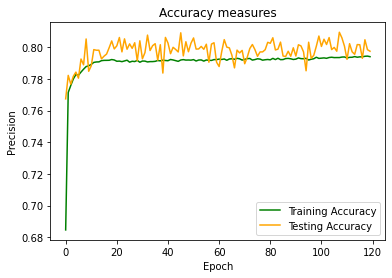

In [30]:
precision = kModel.history['precision']
val_precision = kModel.history['val_precision']

plt.plot(epochs, precision, color='green', label='Training Accuracy')
plt.plot(epochs, val_precision, color='orange', label='Testing Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy measures')
plt.xlabel('Epoch')
plt.ylabel('Precision')

In [31]:
METsignal = []
WEIGHTsignal = []
METbackground = []
WEIGHTbackground = []
Signalscore = []
Backgroundscore = []
Signalscore = allScore[0:len(list_signal)]
Backgroundscore = allScore[len(list_signal):-1]
for i in range(len(allScore)):
    if allScore[i][0] < 0.5:
        
        METsignal.append(Z["mjjoptimized"][i])
        WEIGHTsignal.append(Z["weight"][i])
    if allScore[i][0] >= 0.5:
        
        METbackground.append(Z["mjjoptimized"][i])
        WEIGHTbackground.append(Z["weight"][i])


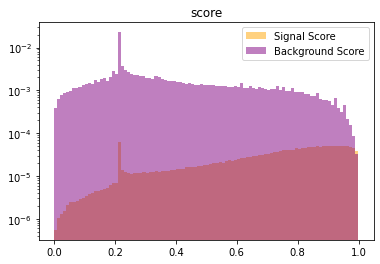

In [32]:
plt.title('score')
plt.hist(Signalscore, bins=100, weights=Z["weight"][0:len(list_signal)], alpha=0.5, color='orange', label='Signal Score')
plt.hist(Backgroundscore, bins=100, weights=Z["weight"][len(list_signal):-1], alpha=0.5, color='purple', label='Background Score')
plt.yscale('log')
plt.legend()
plt.show()

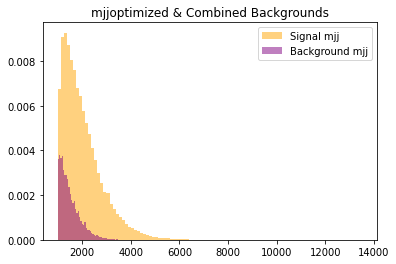

In [33]:
plt.title('mjjoptimized & Combined Backgrounds')
plt.hist(METsignal, bins=100, weights=WEIGHTsignal, alpha=0.5, color='orange', label='Signal mjj')
plt.hist(METbackground, bins=100, weights=WEIGHTbackground, alpha=0.5, color='purple', label='Background mjj')

plt.legend()
plt.show()

In [34]:
def statscheck(Sscore,significance,i):
    print(Sscore[i])
    if Sscore[i] > (0.01*(i+1)):
        S += 1
    return(S)

In [35]:
def Significance(n,b):
    """
    Takes the distribution of events, signal vs background, and outputs a significance value, how impactful the model is
    n is the total number of events
    b is the total number of background events, as defined by a cut on the scores
    sigma is a statistical uncertainty, set arbitrarily
    """
    Zarray = []
    if n == 0 or b == 0:
        Z = 0
        Zarray.append(Z)
        Zarray.append(Z)
        Zarray.append(Z)
    if n != 0 and b != 0:
        for item in [0.1,0.2,0.3]:
            sigma = item*b
            if n > b:
                Z = (2*((n*math.log((n*(b+sigma**2))/(b**2+n*sigma**2)))-(((b**2)/(sigma**2))*math.log(1+((sigma**2*(n-b))/(b*(b+sigma**2)))))))**0.5
            if n < b:
                Z = -1*(2*((n*math.log((n*(b+sigma**2))/(b**2+n*sigma**2)))-(((b**2)/(sigma**2))*math.log(1+((sigma**2*(n-b))/(b*(b+sigma**2)))))))**0.5
            Zarray.append(Z)
    return(Zarray)

In [36]:
def RunSig(allScore,y,dropset,weights):
    """
    Takes the scores predicted by a model for a set of events
    n is the total number of events
    b is the background events
    """
    
    cuts = np.arange(0,1,0.01)
    Sig = []
    integral = []
    b = 0
    n = 0
    Sscore = []
    Bscore = []
    Sweights = []
    Bweights = []
    maskarray = y
    
    Sscore = allScore[:len(allScore)-len(np.ma.MaskedArray.compressed(ma.masked_array(allScore, mask=maskarray)))]
    Bscore = allScore[len(allScore)-len(np.ma.MaskedArray.compressed(ma.masked_array(allScore, mask=maskarray))):len(allScore)-1]
    Sweights = weights[:len(allScore)-len(np.ma.MaskedArray.compressed(ma.masked_array(allScore, mask=maskarray)))]
    Bweights = weights[len(allScore)-len(np.ma.MaskedArray.compressed(ma.masked_array(allScore, mask=maskarray))):len(allScore)-1]
    plt.figure()
    S = plt.hist(Sscore, bins=100, weights = Sweights, range=(0,1), alpha=0.5, color='Blue', label='Signal')[0]
    B = plt.hist(Bscore, bins=100, weights = Bweights, range=(0,1), alpha=0.5, color='Orange', label='Background')[0]
    plt.legend()
    plt.yscale('log')
    plt.show()
    Areas = []
    for i in range(len(S)):
        s = ma.sum(S[i-1:])
        b = ma.sum(B[i-1:])
        Areas.append([s,b])
        n = s+b
        Sig.append(Significance(n,b))
    '''
    for cut in cuts:
        for i in range(len(allScore)):
            if allScore[i] >= cut and allScore[i] < (cut+0.01):
                n += 1*weights[i]
                if y[i] == 0:
                    b += 1*weights[i]
                    Bscore.append(float(allScore[i]))
                    Bweights.append(weights[i])
                else:
                    Sscore.append(float(allScore[i]))
                    Sweights.append(weights[i])
        
            Area = sum(Sweights)
            AUC.append(Area)
        print("AUC =")
        print(Area)
        Sig.append(Significance(n,b))
    '''
    b1 = []
    b2 = []
    b3 = []
    
    for item in Sig:
        b1.append(item[0])
        b2.append(item[1])
        b3.append(item[2])
    plt.figure()
    plt.title('Significance')
    plt.plot(cuts, b1, color='Red', label='0.1b')
    plt.plot(cuts, b2, color='Blue', label='0.2b')
    plt.plot(cuts, b3, color='Green', label='0.3b')
    plt.legend()
    #plt.show() 
    
    return Sig,Sscore,Bscore,Areas,Sweights,Bweights
#plt.figure()
        #plt.title('SvB')
        #plt.hist(Sscore, bins=100, weights = Sweights, range=(0,1), alpha=0.5, color='Blue', label='Signal')
        #plt.hist(Bscore, bins=100, weights = Bweights, range=(0,1), alpha=0.5, color='Orange', label='Background')
        #plt.yscale('log')
        #plt.legend()
        #plt.show()

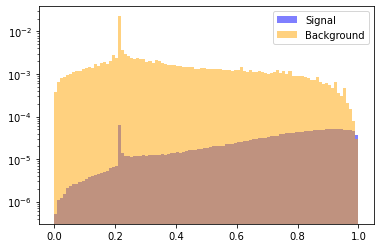

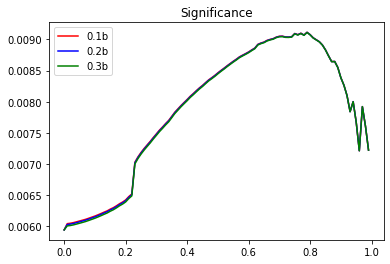

In [37]:
Sig,Sscore,Bscore,Areas,Sweights,Bweights = RunSig(allScore,y,[],Z['weight'])